In [1]:
from pathlib import Path
import h5py
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD

import syft as sy
from syft.core.node.vm.vm import VirtualMachine
from syft.core.node.vm.client import VirtualMachineClient
from syft.ast.module import Module
from syft.core.remote_dataloader import RemoteDataLoader
from syft.core.remote_dataloader import RemoteDataset

print(f'torch version: {torch.__version__}')
print(f'syft version: {sy.__version__}')


torch version: 1.8.1+cu102
syft version: 0.5.0


## Files and Directories

In [2]:
# paths to files and directories
project_path = Path.cwd().parent
print(f'project_path: {project_path}')
data_dir = 'mitdb'
train_name = 'train_ecg.hdf5'
test_name = 'test_ecg.hdf5'
all_name = 'all_ecg.hdf5'
model_dir = 'model'
model_name = 'conv2'
model_ext = '.pth'
csv_dir = 'csv'
csv_ext = '.csv'
csv_name = 'conv2'
csv_accs_name = 'accs_conv2'

project_path: /mnt/batch/tasks/shared/LS_root/mounts/clusters/teslak80-56gbram/code/Users/dkn.work/split-learning-he


## Construct the client and server

In [3]:
server: VirtualMachine = sy.VirtualMachine(name="server")
client: VirtualMachineClient = server.get_root_client()

In [4]:
remote_torch: Module = client.torch
remote_torch

Module:
	.Tensor -> <syft.ast.klass.Class object at 0x7efd95c13280>
	.BFloat16Tensor -> <syft.ast.klass.Class object at 0x7efd95c132e0>
	.BoolTensor -> <syft.ast.klass.Class object at 0x7efd95c13340>
	.ByteTensor -> <syft.ast.klass.Class object at 0x7efd95c133a0>
	.CharTensor -> <syft.ast.klass.Class object at 0x7efd95c13400>
	.DoubleTensor -> <syft.ast.klass.Class object at 0x7efd95c13460>
	.FloatTensor -> <syft.ast.klass.Class object at 0x7efd95c134c0>
	.HalfTensor -> <syft.ast.klass.Class object at 0x7efd95c13520>
	.IntTensor -> <syft.ast.klass.Class object at 0x7efd95c13580>
	.LongTensor -> <syft.ast.klass.Class object at 0x7efd95c135e0>
	.ShortTensor -> <syft.ast.klass.Class object at 0x7efd95c13640>
	.nn -> Module:
		.Parameter -> <syft.ast.klass.Class object at 0x7efd95c13760>
		.Module -> <syft.ast.klass.Class object at 0x7efd95b60c40>
		.Conv2d -> <syft.ast.klass.Class object at 0x7efd95b65160>
		.Dropout2d -> <syft.ast.klass.Class object at 0x7efd95b65580>
		.Linear -> <syft.

## Client: loading and exploring the dataset

In [5]:
class ECG(Dataset):
    # The class used to load the ECG dataset
    def __init__(self, mode='train'):
        if mode == 'train':
            with h5py.File(project_path/data_dir/train_name, 'r') as hdf:
                self.x = torch.tensor(hdf['x_train'][:], dtype=torch.float)
                self.y = torch.tensor(hdf['y_train'][:])                
        elif mode == 'test':
            with h5py.File(project_path/data_dir/test_name, 'r') as hdf:
                self.x = torch.tensor(hdf['x_test'][:], dtype=torch.float)
                self.y = torch.tensor(hdf['y_test'][:])
        else:
            raise ValueError('Argument of mode should be train or test')
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [6]:
train_dataset = ECG(mode='train')
test_dataset = ECG(mode='test')

Let's first get everything in the dataset and see how many examples we have, and how each
of them look like

In [7]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
x_train, y_train = next(iter(train_loader))
x_test, y_test = next(iter(test_loader))
print(f'x_train: {type(x_train)}, {x_train.size()}')
print(f'y_train: {type(y_train)}, {y_train.size()}')
print(f'x_test: {type(x_test)}, {x_test.size()}')
print(f'y_test: {type(y_test)}, {y_test.size()}')

x_train: <class 'torch.Tensor'>, torch.Size([13245, 1, 128])
y_train: <class 'torch.Tensor'>, torch.Size([13245])
x_test: <class 'torch.Tensor'>, torch.Size([13245, 1, 128])
y_test: <class 'torch.Tensor'>, torch.Size([13245])


x_0: torch.Size([1, 128])
unrolling: torch.Size([128])


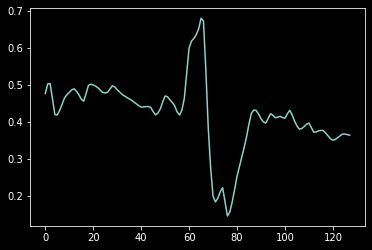

In [8]:
x0 = x_train[0, :, :]
print(f'x_0: {x0.shape}')
x0_unroll = x0.view(-1)
print(f'unrolling: {x0_unroll.shape}')
indx = np.arange(0, 128)

# plt.figure(figsize=(3,3))
plt.style.use('dark_background')
plt.plot(indx, x0_unroll)
plt.show()

The client creates the Dataset object and save it in a `.pt` file. 
If using `duet`, he can send the string path to the server using 
`sy.lib.python.String(string_path).send(duet, pointable=True, tags=["data"])`

In [9]:
torch.save(train_dataset, "train_dataset.pt")
torch.save(test_dataset, "test_dataset.pt")

## Server: creating remote dataset and dataloader

In [10]:
train_rds = RemoteDataset(path='train_dataset.pt', data_type="torch_tensor")
train_rds

<class 'syft.core.remote_dataloader.remote_dataloader.RemoteDataset'>: torch_tensor

From the remote dataset, the server constructs the data loader. Then the server uses `.send`
to create a pointer to do remote data loading

In [11]:
train_rdl = RemoteDataLoader(remote_dataset=train_rds, batch_size=32)
train_rdl_ptr = train_rdl.send(client)
ic(train_rdl, train_rdl_ptr)
# call create_dataset to create the real Dataset object on remote side
train_rdl_ptr.load_dataset()
# call create_dataloader to create the real DataLoader object on remote side
train_rdl_ptr.create_dataloader()

ic| train_rdl: <syft.core.remote_dataloader.remote_dataloader.RemoteDataLoader object at 0x7efd95783df0>
    train_rdl_ptr: <syft.proxy.syft.core.remote_dataloader.RemoteDataLoaderPointer object at 0x7efe500d6430>


In [12]:
for i, b in enumerate(tqdm(train_rdl_ptr)):
    if i<2:
        X, y = b[0], b[1]
        ic(X, y)
        ic(X.get_copy(), y.get_copy())

  0%|          | 0/414 [00:00<?, ?it/s]ic| X: <syft.proxy.syft.lib.python.AnyPointer object at 0x7efd955b1640>
    y: <syft.proxy.syft.lib.python.AnyPointer object at 0x7efd97751940>
ic| X.get_copy(): tensor([[[0.4761, 0.5021, 0.5030,  ..., 0.3667, 0.3652, 0.3637]],
                  
                          [[0.4289, 0.4280, 0.4266,  ..., 0.5638, 0.5616, 0.5601]],
                  
                          [[0.3616, 0.3616, 0.3616,  ..., 0.4379, 0.4326, 0.4278]],
                  
                          ...,
                  
                          [[0.4732, 0.4599, 0.4674,  ..., 0.5969, 0.5994, 0.6010]],
                  
                          [[0.5071, 0.5071, 0.5072,  ..., 0.6265, 0.6249, 0.6236]],
                  
                          [[0.3654, 0.3660, 0.3667,  ..., 0.3375, 0.3387, 0.3395]]])
    y.get_copy(): tensor([2, 4, 2, 4, 2, 1, 1, 1, 2, 1, 0, 0, 2, 4, 3, 1, 2, 4, 1, 0, 1, 0, 4, 2,
                          4, 3, 0, 1, 2, 4, 4, 2])
  0%|          | 1

Similarly, for the test dataset

In [13]:
test_rds = RemoteDataset(path='test_dataset.pt', data_type="torch_tensor")
test_rdl = RemoteDataLoader(remote_dataset=test_rds, batch_size=32)
test_rdl_ptr = test_rdl.send(client)
ic(test_rds, test_rdl, test_rdl_ptr)
# call create_dataset to create the real Dataset object on remote side
test_rdl_ptr.load_dataset()
# call create_dataloader to create the real DataLoader object on remote side
test_rdl_ptr.create_dataloader()

ic| test_rds: <class 'syft.core.remote_dataloader.remote_dataloader.RemoteDataset'>: torch_tensor
    test_rdl: <syft.core.remote_dataloader.remote_dataloader.RemoteDataLoader object at 0x7efd95783190>
    test_rdl_ptr: <syft.proxy.syft.core.remote_dataloader.RemoteDataLoaderPointer object at 0x7efd958a3d30>


In [14]:
for i, b in enumerate(test_rdl_ptr):
    if i<2:
        X, y = b[0], b[1]
        ic(X, y)
        ic(X.get_copy(), y.get_copy())

ic| X: <syft.proxy.syft.lib.python.AnyPointer object at 0x7efd955c9c70>
    y: <syft.proxy.syft.lib.python.AnyPointer object at 0x7efd95783430>
ic| X.get_copy(): tensor([[[0.4378, 0.4380, 0.4382,  ..., 0.3650, 0.3653, 0.3656]],
                  
                          [[0.3724, 0.3577, 0.3532,  ..., 0.4559, 0.4563, 0.4621]],
                  
                          [[0.3691, 0.3687, 0.3683,  ..., 0.4174, 0.4165, 0.4158]],
                  
                          ...,
                  
                          [[0.4871, 0.4874, 0.4877,  ..., 0.4661, 0.4672, 0.4679]],
                  
                          [[0.4054, 0.4028, 0.3990,  ..., 0.4981, 0.5023, 0.5059]],
                  
                          [[0.4811, 0.4434, 0.4642,  ..., 0.8065, 0.8028, 0.7990]]])
    y.get_copy(): tensor([1, 3, 0, 0, 3, 2, 3, 1, 1, 1, 1, 4, 1, 1, 1, 2, 1, 0, 4, 1, 0, 4, 4, 1,
                          4, 2, 0, 2, 4, 1, 3, 4])
ic| X: <syft.proxy.syft.lib.python.AnyPointer object at 0

## Server: define the spit neural network used to train on the ECG dataset

Client's side contains conv layers

In [15]:
class EcgClient(sy.Module):
    # used by the data owners
    def __init__(self, torch_ref):
        super(EcgClient, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv1d(1, 16, 7, padding=3)  # 128 x 16
        self.relu1 = self.torch_ref.nn.LeakyReLU()
        self.pool1 = self.torch_ref.nn.MaxPool1d(2)  # 64 x 16
        self.conv2 = self.torch_ref.nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu2 = self.torch_ref.nn.LeakyReLU()
        self.pool2 = self.torch_ref.nn.MaxPool1d(2)  # 32 x 16
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 32 * 16)
        return x

Server's side contains fully connected layers

In [16]:
class EcgServer(sy.Module):
    def __init__(self, torch_ref):
        super(EcgServer, self).__init__(torch_ref=torch_ref)
        self.linear3 = nn.Linear(32 * 16, 128)
        self.relu3 = nn.LeakyReLU() 
        self.linear4 = nn.Linear(128, 5)
        self.softmax4 = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        x = self.softmax4(x)
        return x

## Server: training process

In [17]:
ecg_client = EcgClient(torch_ref=torch)
checkpoint = torch.load("init_weight.pth")
ecg_client.conv1.weight.data = checkpoint["conv1.weight"]
ecg_client.conv1.bias.data = checkpoint["conv1.bias"]
ecg_client.conv2.weight.data = checkpoint["conv2.weight"]
ecg_client.conv2.bias.data = checkpoint["conv2.bias"]

ecg_server = EcgServer(torch_ref=torch)
checkpoint = torch.load("init_weight.pth")
ecg_server.linear3.weight.data = checkpoint["linear3.weight"]
ecg_server.linear3.bias.data = checkpoint["linear3.bias"]
ecg_server.linear4.weight.data = checkpoint["linear4.weight"]
ecg_server.linear4.bias.data = checkpoint["linear4.bias"]

# Send the client's model to the client
ecg_client_ptr = ecg_client.send(client)

Some hyper-parameters

In [18]:
total_batch = 414  # 32*414=13248. We have 13245 data samples

epoch = 400
criterion = nn.CrossEntropyLoss()
lr = 0.001

optim_client = remote_torch.optim.Adam(params=ecg_client_ptr.parameters(), lr=lr)
optim_server = torch.optim.Adam(params=ecg_server.parameters(), lr=lr)

seed = 0  # the meaning of life
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Training (with CPU)

In [19]:
train_losses = list()
train_accs = list()
test_losses = list()
test_accs = list()
best_test_acc = 0  # best test accuracy
for e in range(epoch):
    print(f"Epoch {e+1} - train ", end='')
    
    train_loss = 0.0
    correct, total = 0, 0
    for i, batch in enumerate(tqdm(train_rdl_ptr)):
        x_ptr, y_gt_ptr = batch[0], batch[1]
        # ic(x.get_copy(), y.get_copy())
        # initialize all gradients to zero
        optim_server.zero_grad()
        optim_client.zero_grad()
        # compute and get the activation signals from the first half of the network
        activs_ptr = ecg_client_ptr(x_ptr)
        # the server still gets access to plain activation signals
        activs = activs_ptr.clone().get(request_block=True)
        # the server continues the forward pass on the activation maps
        y_hat = ecg_server(activs)
        # the server asks to access ground truths in plain text
        y_gt = y_gt_ptr.get_copy()
        # calculates cross-entropy loss
        loss = criterion(y_hat, y_gt)
        train_loss += loss.item()
        correct += torch.sum(y_hat.argmax(dim=1) == y_gt).item()
        # backward propagation (calculating gradients of the loss w.r.t the weights)
        loss.backward()
        # send the gradients to the client
        client_grad_ptr = activs.grad.clone().send(client)
        # update the gradients of the client's model
        activs_ptr.backward(client_grad_ptr)
        # update the weights based on the gradients
        optim_client.step()
        optim_server.step()
        total += len(y_gt)

    train_losses.append(train_loss / total_batch)
    train_accs.append(correct / total)

    print(f'loss: {train_losses[-1]: .4f}, accuracy: {train_accs[-1]*100: 2f}')

    # testing
    with torch.no_grad():  
        test_loss = 0.0
        correct, total = 0, 0
        for i, batch in enumerate(tqdm(test_rdl_ptr)):
            x_ptr, y_gt_ptr = batch[0], batch[1]
            # forward pass
            activs_ptr = ecg_client_ptr(x_ptr)
            activs = activs_ptr.clone().get(request_block=True)
            y_hat = ecg_server(activs)
            # the server asks to access ground truths in plain text
            y_gt = y_gt_ptr.get_copy()
            # calculate test loss
            loss = criterion(y_hat, y_gt)
            test_loss += loss.item()
            correct += torch.sum(y_hat.argmax(dim=1) == y_gt).item()
            total += len(y_gt)

        test_losses.append(test_loss / total_batch)
        test_accs.append(correct / total)
        print(f'test_loss: {test_losses[-1]: .4f}, test_acc: {test_accs[-1]*100: 2f}')
        
    if test_accs[-1] > best_test_acc:
        best_test_acc = test_accs[-1]

Epoch 1 - train loss:  1.3243, accuracy:  59.041148
test_loss:  1.1502, test_acc:  78.391846
Epoch 2 - train loss:  1.0875, accuracy:  83.057758
test_loss:  1.0550, test_acc:  85.730464
Epoch 3 - train loss:  1.0533, accuracy:  85.654964
test_loss:  1.0352, test_acc:  87.180068
Epoch 4 - train loss:  1.0423, accuracy:  86.621367
test_loss:  1.0261, test_acc:  88.070970
Epoch 5 - train loss:  1.0350, accuracy:  87.240468
test_loss:  1.0218, test_acc:  88.478671
Epoch 6 - train loss:  1.0306, accuracy:  87.580219
test_loss:  1.0184, test_acc:  88.682522
Epoch 7 - train loss:  1.0270, accuracy:  87.889770
test_loss:  1.0208, test_acc:  88.614572
Epoch 8 - train loss:  1.0258, accuracy:  87.950170
test_loss:  1.0208, test_acc:  88.493771
Epoch 9 - train loss:  1.0245, accuracy:  88.101170
test_loss:  1.0184, test_acc:  88.659872
Epoch 10 - train loss:  1.0216, accuracy:  88.289921
test_loss:  1.0123, test_acc:  89.188373
Epoch 11 - train loss:  1.0219, accuracy:  88.244621
test_loss:  1.01

  0%|          | 0/414 [00:00<?, ?it/s]/anaconda/envs/SyftEnv/lib/python3.9/site-packages/syft/lib/torch/uppercase_tensor.py:30: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  grad = getattr(obj, "grad", None)
 73%|███████▎  | 302/414 [01:08<00:16,  6.61it/s]